## MyBuilder.com Tech Task
### Giacomo Vannucchi - 07/11/2018

In [365]:
import pandas as pd
import psycopg2
import config as c
import pandas.io.sql as sqlio
from ggplot import *
from datetime import datetime

In [366]:
conn = psycopg2.connect(host=c.host,
                        database=c.data_base,
                        user=c.user_name,
                        password=c.password
                        )

## Quation 1
We think there is a seasonality factor to our NPS data for tradesman. Splice the data and show how seasonality affects our service, giving an example or two as to why NPS may go up/down throughout the year.

#### Monthly Trend Analysis:

In [367]:
query_monthly = """
WITH final_table AS (

		WITH mid_table AS 
			( 
			SELECT cohort_year, cohort_month, AVG(net_promoter_score) as monthly_average_score 
			FROM 
				(SELECT 
				DATE_PART('month',end_of_period) as cohort_month, 
				DATE_PART('year',end_of_period) AS cohort_year,*
				FROM customer_happiness_cohorts
				WHERE type = 'tradesman') t
			GROUP BY cohort_year,cohort_month
			ORDER BY monthly_average_score DESC
			) 
			SELECT 
				cohort_year,cohort_month, 
				monthly_average_score, 
				AVG(monthly_average_score) OVER (order by cohort_year, cohort_month rows between 1 preceding and 2 following) as moving_average 
			FROM mid_table
			order by cohort_year, cohort_month asc
			)
SELECT 
	cohort_year,cohort_month, 
	monthly_average_score/moving_average AS seasonal_index,
	monthly_average_score,
	moving_average
FROM final_table
ORDER BY seasonal_index DESC
;
"""

In [368]:
data_m = sqlio.read_sql_query(query_monthly, conn)

In [369]:
data_m.head()

,cohort_year,cohort_month,seasonal_index,monthly_average_score,moving_average
0,2015.0,12.0,1.294396,41.0,31.6750
1,2016.0,11.0,1.236695,30.5,24.6625
2,2017.0,12.0,1.236133,19.5,15.7750
3,2018.0,1.0,1.189409,14.6,12.2750
4,2016.0,4.0,1.160372,26.5,22.8375


In [370]:
data_m["period"] = data_m["cohort_year"].map(int).map(str) + data_m["cohort_month"].map(int).map(str)

In [371]:
data_m["period"] = pd.to_datetime(data_m["period"],format='%Y%m')

In [372]:
data_m["period"] = data_m["period"].dt.strftime('%y-%m')

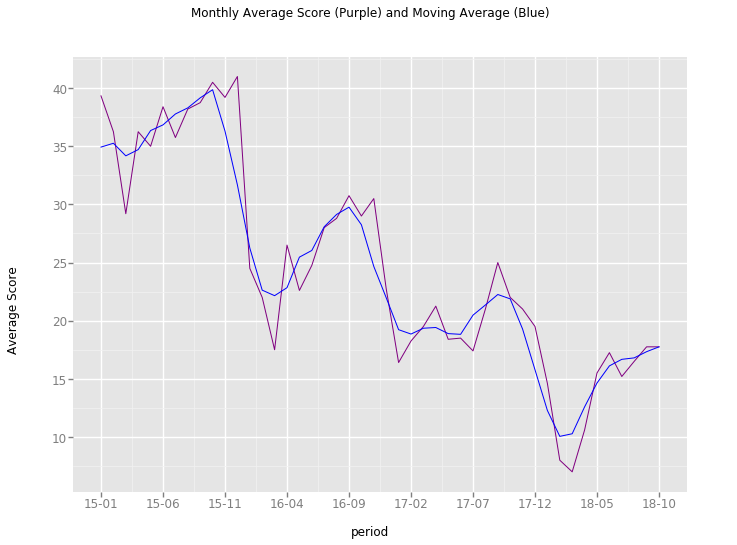

<ggplot: (7555426985)>

In [373]:
ggplot(aes(x='period'), data = data_m)+\
        geom_line(aes(y='monthly_average_score', color='purple'))+\
        geom_line(aes(y='moving_average', color='blue'))+\
        scale_x_continuous(breaks = range(0,50,5))+\
        ylab('Average Score')+\
        ggtitle("Monthly Average Score (Purple) and Moving Average (Blue)")

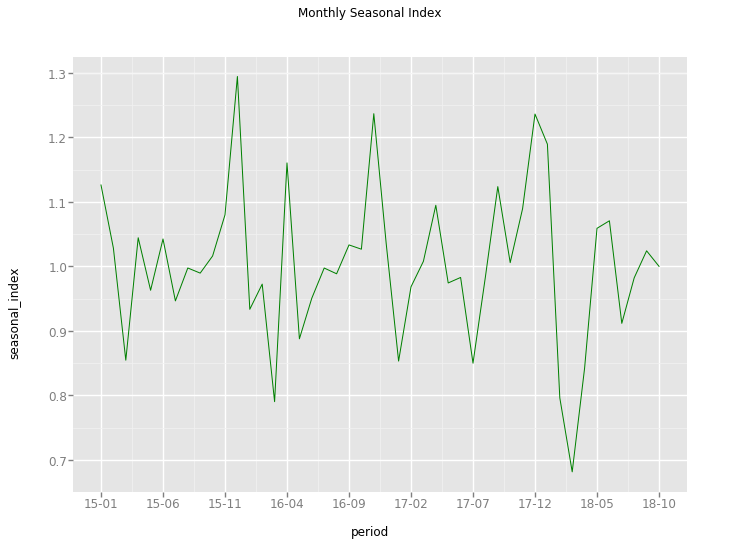

<ggplot: (7554341829)>

In [374]:
ggplot(aes(x='period', y='seasonal_index'), data = data_m)+\
        geom_line(color='green')+\
        scale_x_continuous(breaks = range(0,50,5))+\
        ggtitle("Monthly Seasonal Index")

#### Quarterly Trend Analysis:

In [375]:
query_quarterly = """
WITH final_table AS (

		WITH mid_table AS 
			( 
			SELECT cohort_year, cohort_quarter, AVG(net_promoter_score) as quarterly_average_score 
			FROM 
				(SELECT 
				DATE_PART('quarter',end_of_period) as cohort_quarter, 
				DATE_PART('year',end_of_period) AS cohort_year,*
				FROM customer_happiness_cohorts
				WHERE type = 'tradesman') t
			GROUP BY cohort_year,cohort_quarter
			ORDER BY quarterly_average_score DESC
			) 
			SELECT 
				cohort_year,cohort_quarter, 
				quarterly_average_score, 
				AVG(quarterly_average_score) OVER (order by cohort_year, cohort_quarter rows between 1 preceding and 2 following) as moving_average 
			FROM mid_table
			order by cohort_year, cohort_quarter asc
			)
SELECT 
	cohort_year,cohort_quarter, 
	quarterly_average_score/moving_average AS seasonal_index,
	quarterly_average_score,
	moving_average
FROM final_table
ORDER BY seasonal_index DESC
;
"""

In [376]:
data = sqlio.read_sql_query(query_quarterly, conn)

In [377]:
data["period"] = data["cohort_year"].map(int).map(str) + 'Q' + data["cohort_quarter"].map(int).map(str)

In [381]:
quarterly_table = data.head()

In [382]:
quarterly_table

,cohort_year,cohort_quarter,seasonal_index,quarterly_average_score,moving_average,period
0,2015.0,4.0,1.299315,40.153846,30.903846,2015Q4
1,2017.0,4.0,1.265116,20.923077,16.538462,2017Q4
2,2016.0,3.0,1.177019,29.153846,24.769231,2016Q3
3,2016.0,4.0,1.172809,27.538462,23.480769,2016Q4
4,2017.0,3.0,1.169364,20.846154,17.826923,2017Q3


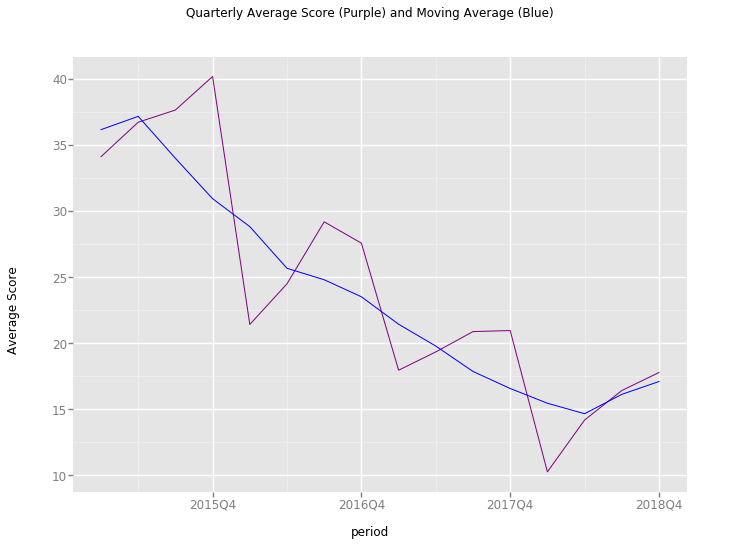

<ggplot: (7554360219)>

In [379]:
ggplot(aes(x='period'), data = data)+\
        geom_line(aes(y='quarterly_average_score', color='purple'))+\
        geom_line(aes(y='moving_average', color='blue'))+\
        scale_x_continuous(breaks = (3,7,11,15))+\
        ylab('Average Score')+\
        ggtitle("Quarterly Average Score (Purple) and Moving Average (Blue)")

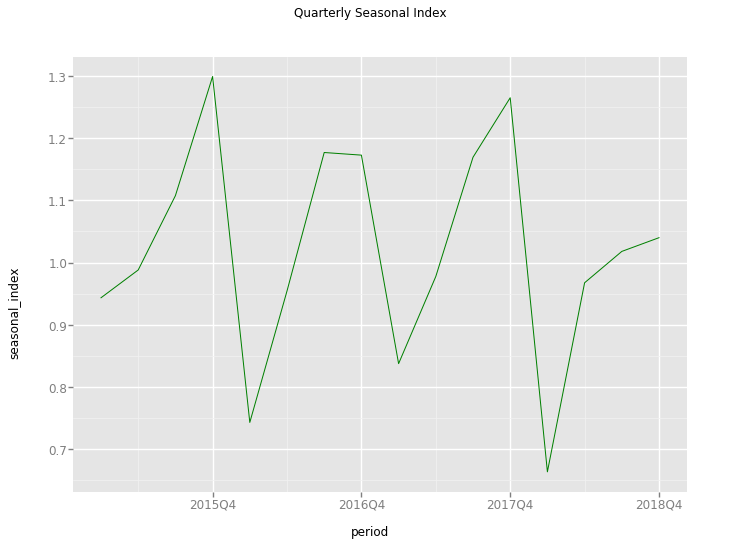

<ggplot: (-9223372029300498067)>

In [380]:
ggplot(aes(x='period', y='seasonal_index'), data = data)+\
        geom_line(color='green')+\
        scale_x_continuous(breaks = (3,7,11,15))+\
        ggtitle("Quarterly Seasonal Index")

### Answer:

The Analysis shows that there is a clear seasonality in the NPS index. 

An index above 1 means that the quarter has a performance higher than average trend, while an index below 1 shows the opposite.

As we can see from the quarterly table and quarterly seasonality plot, the best performing quarters in terms of NPS are Q3 and Q4, consistently over indexing during the years. Q1, on the other hand, is consistently scoring the lowest NPS.

An explanation for this trend can be the fact that volume of job requests on the platform are higher during Q4, and lower during Q1. The hypothesis is that tradesmen tend to be happier when busy with work as there are more opportunities and they are more likely to win jobs.

To validate this assumption we would need to look at total volume of jobs posted on the platfrom over time, but the data is not available at this stage.

A possible explaination of why Q4 tend to be busier than other quarters can be the fact that most of the households look for building contractors with at least 6 months before starting the actual job, in order to get required permissions and not being in a rush. This means that a lot of jobs advertised in Q4, will actually start in Q2 as spring and better weather facilitate works and renovations.

On the other hand Q1 is typically a flat quarter for a lot of businesses, people are back from holydays, where they have spent some money, and work takes a bit of time before returning at full pace.



## Question 2
Marketing comes to the tech team and says that they want to run a campaign to to
get more tradespeople on the site. Given the data from NPS, what recommendation
would you make as to which types and locations they should focus on and why?

In [383]:
query_3 = """
 WITH latest_users_survey AS (
	SELECT customer_happiness_questions_id
		FROM (
		SELECT customer_happiness_questions_id, 
		ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY last_interest_expressed_at DESC) AS rn
		FROM tradesmen_last_interest
		) t
		WHERE rn = 1
		)
	SELECT 
	CASE
		WHEN chq.rating < 7 THEN 'Detractor'
		WHEN chq.rating > 8 THEN 'Promoter'
		ELSE 'Passive'
	END as user_type,
 	chq.user_id,
 	tl.county,
    tt.name as trade
 	FROM customer_happiness_questions chq
 	JOIN latest_users_survey lus ON chq.id = lus.customer_happiness_questions_id
 	JOIN tradesman_locations tl ON tl.user_id = chq.user_id
 	JOIN (
 		SELECT *
		FROM tradesmen_trades 
		WHERE pref_rank = 1 
 		)tt ON tl.user_id = tt.user_id -- using only top ranked trade for simplicity
 ;
"""

In [384]:
data_3 = sqlio.read_sql_query(query_3, conn)

In [385]:
county_size = data_3.groupby(['county']).size().reset_index(name='count_users')

In [386]:
county_size = county_size.sort_values(by = ['count_users'], ascending=False)

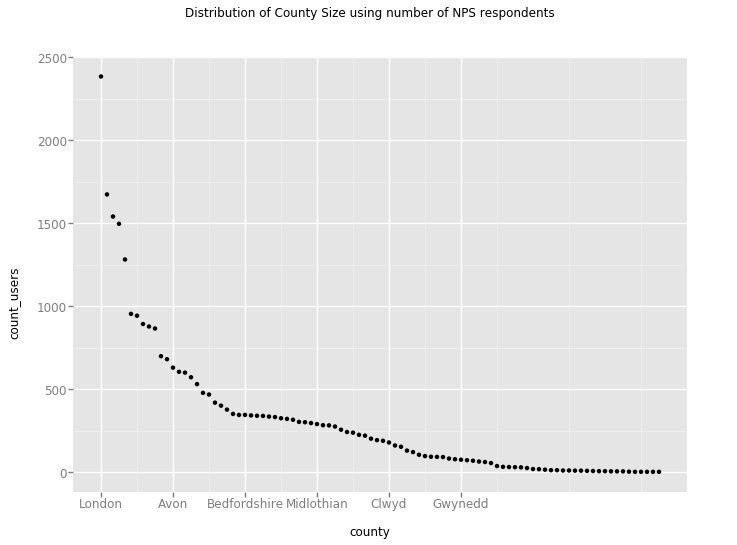

<ggplot: (7556819983)>

In [399]:
ggplot(aes(x = "county", y = "count_users"),data = county_size)+\
        geom_point()+\
        scale_x_continuous(breaks = (0,12,24,36,48,60))+\
        ggtitle("Distribution of County Size using number of NPS respondents")

In [388]:
## Create a list of counties with less than 200 users 
small_counties = county_size[county_size["count_users"] <= 200]["county"].unique().tolist()

In [395]:
## Let's rename this small counties as Small Counties group
data_3.loc[data_3.county.isin(small_counties), 'county'] = 'small_counties'

In [396]:
counties = data_3.groupby(['county', 'user_type']).size().reset_index(name='count_users')

In [397]:
counties = counties.sort_values(by = ['count_users'], ascending=False)

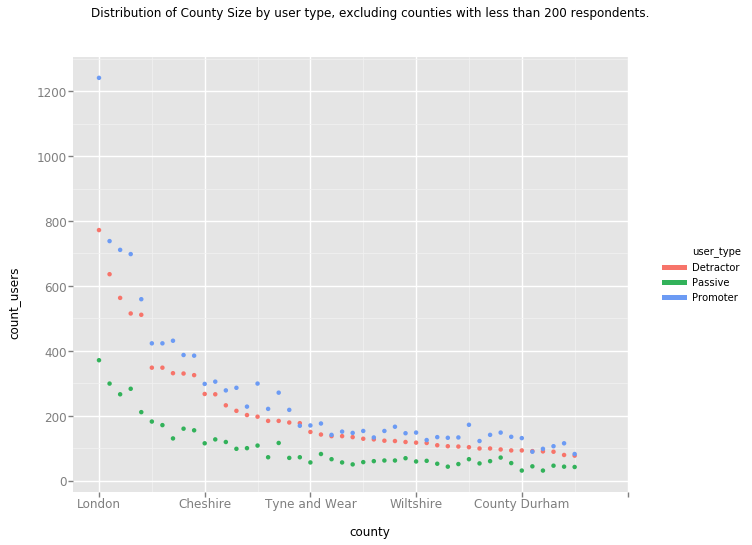

<ggplot: (-9223372029297944702)>

In [401]:
ggplot(aes(x = "county", y = "count_users", color = 'user_type'),data = counties[counties["county"] != "small_counties"])+\
        geom_point()+\
        scale_x_continuous(breaks = (0,10,20,30,40,50))+\
        ggtitle("Distribution of County Size by user type, excluding counties with less than 200 respondents.")

In [402]:
# Let's have a look at the counties with higher percentage of detractors

In [403]:
counties = data_3.groupby(['county', 'user_type']).size().to_frame()

In [404]:
counties_pcts = counties.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [405]:
counties_pcts = counties_pcts.reset_index()

In [406]:
counties_pcts.rename(columns={0:'percent_users'}, inplace=True) 

In [407]:
top_10_detractor_counties = counties_pcts[counties_pcts['user_type'] == 'Detractor'].sort_values(by = ['percent_users'], ascending=False).head(10)

In [240]:
top_10_detractor_counties_list = top_10_detractor_counties["county"].unique().tolist()

In [321]:
data_detractor = data_3[(data_3['county'].isin(top_10_detractor_counties_list)) & (data_3['user_type'] == 'Detractor')]

In [344]:
## Below is the analysis on the Trades.

In [347]:
trades  = data_3.groupby(['trade', 'user_type']).size().to_frame()

In [348]:
trades_pcts = trades.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [349]:
trades_pcts = trades_pcts.reset_index()

In [350]:
trades_pcts.rename(columns={0:'percent_users'}, inplace=True) 

In [351]:
top_10_detractor_trades = trades_pcts[trades_pcts['user_type'] == 'Detractor'].sort_values(by = ['percent_users'], ascending=False).head(10)

In [408]:
top_10_detractor_counties

,county,user_type,percent_users
126,West Sussex,Detractor,42.344498
120,West Glamorgan,Detractor,41.095890
87,North Yorkshire,Detractor,40.625000
24,Derbyshire,Detractor,40.483384
117,Tyne and Wear,Detractor,39.893617
114,Surrey,Detractor,39.890710
30,Dorset,Detractor,39.825581
3,Bedfordshire,Detractor,39.825581
9,Buckinghamshire,Detractor,39.687500
15,Cheshire,Detractor,39.264706


In [353]:
top_10_detractor_trades

,trade,user_type,percent_users
96,Security Systems,Detractor,53.043478
18,Central Heating,Detractor,49.595687
54,Gas Work,Detractor,49.294245
105,Tree Surgery,Detractor,48.850575
39,Electrical,Detractor,45.845511
33,Demolition & Clearing,Detractor,43.298969
72,Locksmiths,Detractor,41.353383
63,Insulation,Detractor,40.000000
78,New Builds,Detractor,39.325843
87,Plumbing,Detractor,38.273491


### Answer:

The `top_10_detractor_counties` table contains the name of the top 10 counties (excluding small counties) with the higher % of detractors over the total of respondents.

Our recommendation to the Marketing team is to focus their campaigns on these counties, in order to compensate for the likely low level of word of month, and potentially compensate a negative publicity coming from the detractors.

Further more a similar investigation has been performed to identify top 10 trades with higher percentage of detractors. and the results as shown in table `top_10_detractor_trades`. Again the receommendation to Marketing team is to target tradesman in those trades.